# Individual Contribution
#### by Theo Marill

### Data Description

The data of interest for this project is a player and session information of gamers using a free Minecraft server hosted and monitored by the Pacific Laboratory for Artificial Intelligence at the University of British Columbia studying player behaviours in service of developing embodied AI. Two `.csv` files called `players` and `sessions` comprise our data, with 196 player observations and 1535 session observations. 

   - The 7 player observations include:
        1. `experience` - The player's minecraft experience (Beginner, Amateur, Regular, Pro, or Veteran)
        2. `subscribe` - TRUE if they subscribe to the newsletter or FALSE otherwise
        3. `hashedEmail` - Their hashed email
        4. `played_hours` How many hours they have played on the server (hours)
        5. `name` - Their in-game name
        2. `gender` - Their gender
        6. `Age` - Their age (years)
   - The 5 session oberservations include:
        1. `hashedEmail` - The player's hashed email
        2. `start_time` - The start time (human readable date and time)
        3. `end_time` - The end time (human readable date and time)
        2. `original_start_time` - The start time (Unix timestamp)
        4. `original_end_time` - The end time (Unix timestamp)

Some potential issues will be the minimal missing data values in `Age`, `end_time` and `original_end_time`.  
The Unix Timestamps are given with less accuracy than the human readable times. But the human readable dates and times are of the 'character' data type and not easily calculatable.   
The reliability of the player data will need to be kept in mind as all users are reporting their experience level, gender, age, etc. anonymously.    
The same person might also have created multiple log-ins with different emails.    
        

### Question

My question is: Is the experience level of players predictive of playing sessions at certain times of day?

Uncovering this may help to find out if recruiting efforts should be targeted to experience levels or cast widely depending on if different experience levels stress the servers' available licenses or let them be spread out throughout the day. To answer this, I will need to convert the unix times into the times of day or learn how to extract the times of day from the `start_time` column.

### Exploratory Data Analysis and Visualization

#### The Data:  

First let's load our R packages:

In [124]:
# run this cell
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Then let's assign our data to the objects, `players` and `sessions`.

In [101]:
# run this cell
raw_players <- read_csv("https://raw.githubusercontent.com/Booch58/individual_contribution/refs/heads/main/players.csv", show_col_types = FALSE)
raw_sessions <- read_csv("https://raw.githubusercontent.com/Booch58/individual_contribution/refs/heads/main/sessions.csv", show_col_types = FALSE)
raw_players
raw_sessions

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


#### Tidying the Data

I will standardize the column naming as well as separate the start *date* and the *time* of `start_time`.

In [138]:
# run this cell
players <- raw_players |>
    rename(hashed_email = hashedEmail, age = Age)|>
    mutate(experience = as_factor(experience), gender = as_factor(gender), hashed_email = fct_reorder(hashed_email, played_hours, .fun = sum))
sessions <- raw_sessions |>
    rename(hashed_email = hashedEmail) |>
    separate(col = start_time, into = c('start_date', 'start_time'), sep = " ")|>
    separate(col = start_time, into = c('start_hr', 'start_m'), sep = ":") |>
    mutate(start_time = as.double(start_hr) * 60 + as.double(start_m)) |>
    separate(col = end_time, into = c('end_date', 'end_time'), sep = " ")|>
    separate(col = end_time, into = c('end_hr', 'end_m'), sep = ":") |>
    mutate(end_time = as.double(end_hr) * 60 + as.double(end_m)) |>
    select(-start_hr, -start_m, -end_hr, -end_m)
players
sessions

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<fct>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashed_email,start_date,end_date,original_start_time,original_end_time,start_time,end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,30/06/2024,1.71977e+12,1.71977e+12,1092,1104
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,17/06/2024,1.71867e+12,1.71867e+12,1413,1426
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,25/07/2024,1.72193e+12,1.72193e+12,1054,1077
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024,28/07/2024,1.72218e+12,1.72218e+12,936,957
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024,25/07/2024,1.72189e+12,1.72189e+12,375,382
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024,20/05/2024,1.71617e+12,1.71617e+12,146,165


- Now, `hashedEmail` has become `hashed_email` in line with the other column names that use underscores.
- Now, `Age` has become `age` in line with all lowercase letters for colmun names.
- Now, `experience` and `gender` have also become categorical factor data types.
- Now, `start_time` and `end_time` has been split into `start_date` and `end_date` with the date and `start_time` and `end_time` as doubles with the time in minutes past midnight.

#### Means of quantitative variables

In [135]:
# run this cell
mean_all <- players |>  
    select(subscribe, played_hours) |>
    map_dfr(mean) |>
    bind_cols(map_dfr(select(sessions, start_time, end_time, original_start_time, original_end_time), mean, na.rm = TRUE))
mean_all

subscribe,played_hours,start_time,end_time,original_start_time,original_end_time
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7346939,5.845918,641.1987,605.6354,1.719201e+12,1.719196e+12


**Interpretation:**
- `subscribe` ~0.735% of players subscribe to the newsletter.
- `played_hours` ~5.846 hours is the average total playtime of a player
- `start_time` ~10:41 am is the average time of day for the start of a session
- `end_time` ~10:05 am is the average time of day for the end of a session
- `original_start_time` ~Sunday June 23, 2024 8:50 pm was the average time between all start times
- `original_end_time` ~Sunday June 23, 2024 7:26 pm was the average time between all end times

#### Exploratory Visualizations

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


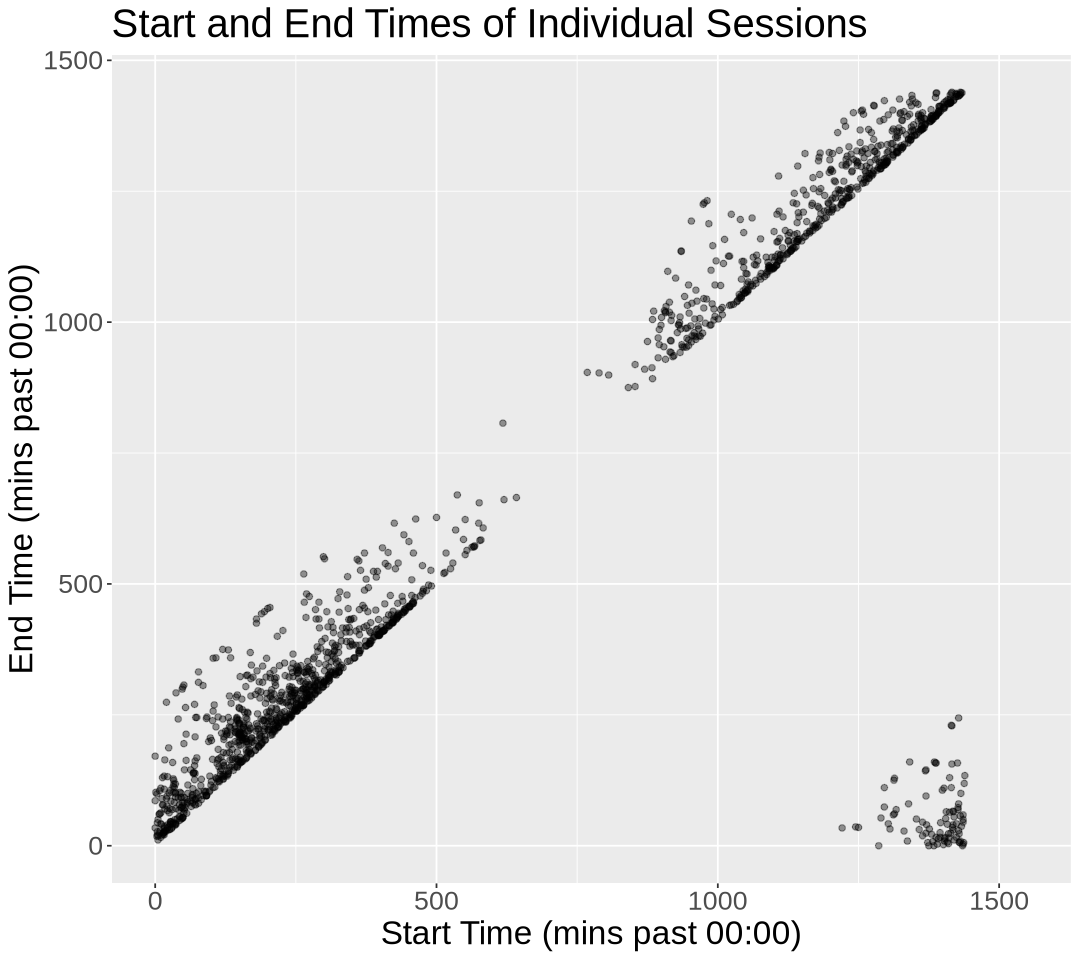

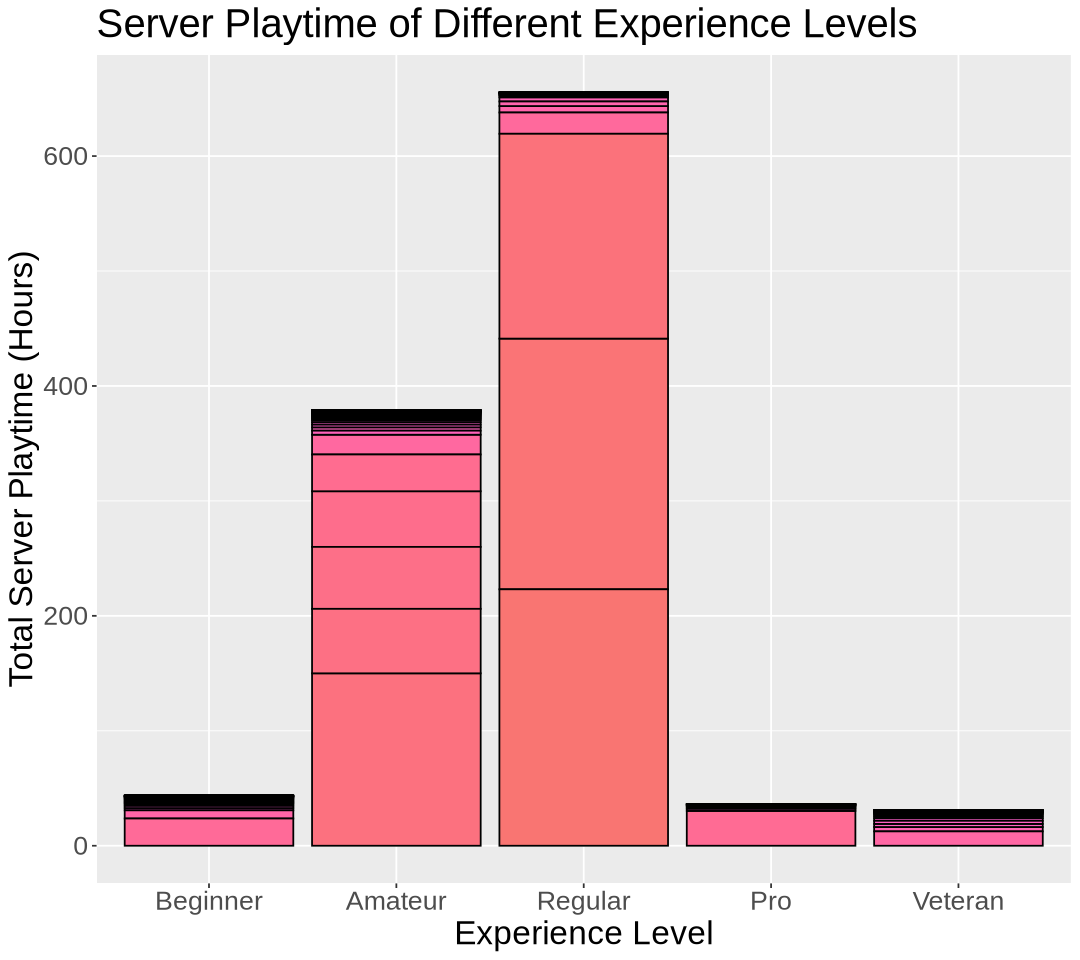

In [147]:
options(repr.plot.width = 9, repr.plot.height = 8)

start_vs_end <- ggplot(sessions, aes(x=start_time, y=end_time)) +
    geom_point(alpha = 0.4) +
    labs(title="Start and End Times of Individual Sessions",
         x="Start Time (mins past 00:00)",
         y="End Time (mins past 00:00)",) +
    xlim(0,1550) +
    theme(text = element_text(size = 20)) 
experience_hours <- ggplot(players, aes(x = factor(experience, levels = c("Beginner","Amateur","Regular","Pro","Veteran")), 
                                        y = played_hours,
                                        fill = hashed_email)) +
    geom_bar(stat = "identity", colour = "black") +
    labs(title="Server Playtime of Different Experience Levels",
         x="Experience Level",
         y="Total Server Playtime (Hours)") +
    theme(legend.position = "none", text = element_text(size = 20)) 

start_vs_end
experience_hours